In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing

In [146]:
input_data = np.arange(0, 1000)
output_data = np.zeros((1000,2), dtype=int)
output_data[500:,0] = 1
output_data[:500,1] = 1
nr_params = output_data.shape[1]
nr_datapoints = input_data.shape[0]; nr_params, nr_datapoints

(2, 1000)

In [147]:
X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_data)
Scaler = preprocessing.StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train.reshape(-1,1))
X_test_scaled = Scaler.transform(X_test.reshape(-1,1))

In [148]:
train_error = []
test_error = []

In [152]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

class NeuralNetwork:
    def __init__(
            self,
            X_data,
            Y_data,
            n_hidden_neurons=50,
            n_categories=10,
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0):

        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_hidden_neurons = n_hidden_neurons
        self.n_categories = n_categories

        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd

        self.create_biases_and_weights()

    def create_biases_and_weights(self):
        self.hidden_weights = np.random.randn(self.n_features, self.n_hidden_neurons)
        self.hidden_bias = np.zeros(self.n_hidden_neurons) + 0.01

        self.output_weights = np.random.randn(self.n_hidden_neurons, self.n_categories)
        self.output_bias = np.zeros(self.n_categories) + 0.01

    def feed_forward(self):
        # feed-forward for training
        self.z_h = np.matmul(self.X_data, self.hidden_weights) + self.hidden_bias
        self.a_h = sigmoid(self.z_h)

        self.z_o = np.matmul(self.a_h, self.output_weights) + self.output_bias

        exp_term = np.exp(self.z_o)
        self.probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)

    def feed_forward_out(self, X):
        # feed-forward for output
        z_h = np.matmul(X, self.hidden_weights) + self.hidden_bias
        a_h = sigmoid(z_h)

        z_o = np.matmul(a_h, self.output_weights) + self.output_bias
        
        exp_term = np.exp(z_o)
        probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        return probabilities

    def backpropagation(self):
        error_output = self.probabilities - self.Y_data
        error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h * (1 - self.a_h)

        self.output_weights_gradient = np.matmul(self.a_h.T, error_output)
        self.output_bias_gradient = np.sum(error_output, axis=0)

        self.hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
        self.hidden_bias_gradient = np.sum(error_hidden, axis=0)

        if self.lmbd > 0.0:
            self.output_weights_gradient += self.lmbd * self.output_weights
            self.hidden_weights_gradient += self.lmbd * self.hidden_weights

        self.output_weights -= self.eta * self.output_weights_gradient
        self.output_bias -= self.eta * self.output_bias_gradient
        self.hidden_weights -= self.eta * self.hidden_weights_gradient
        self.hidden_bias -= self.eta * self.hidden_bias_gradient

    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        return np.argmax(probabilities, axis=1)

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]

                self.feed_forward()
                self.backpropagation()
            xtest = nn.predict(self.X_data_full)
            test_error.append(accuracy_score2(self.Y_data_full, xtest))

In [156]:
def accuracy_score(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

def accuracy_score2(Y_test, Y_pred):
    return np.sum(np.argwhere(Y_test==1)[:,1] == Y_pred)/len(Y_test)

In [164]:
nn = NeuralNetwork( X_train_scaled,
                    Y_train,
                    n_hidden_neurons=1,
                    n_categories=2,
                    epochs=2000,
                    batch_size=32,
                    eta=0.001,
                    lmbd=0.0)
nn.train()

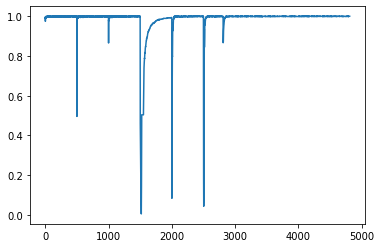

In [165]:
plt.plot(test_error)